In [1]:
%load_ext autoreload
%autoreload 1

%aimport src.utils.tardisml_utils

In [2]:
%reload_ext autoreload

In [ ]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl

from src.data_preparation import mdl_dataset_prep as dataset_prep

import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.feature_extraction.pca as feature_pca
import src.visualization.visualize_pca as visualize_pca
import src.visualization.visualize_error as visualize_error
from src.visualization import mdl_introspect

from src.data_preparation.blocking_time_series_split import BlockingTimeSeriesSplit 
from src.data_preparation import mdl_dataset_prep
from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

In [ ]:
# Date to plot in example
idate = 100
# Path to config file
file_config = '../config/data_proc_full.yaml'
# file_config = '../config/data_proc_demo.yaml'

# Path to template file
file_template = '../config/template_name.yaml'

template = yaml.load(open(file_template),Loader=yaml.FullLoader)
load_config.update_config(file_config, verbose=True)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir = load_config.load_filename(file_config, verbose=True)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)
ml_model, nseq, params = load_config.load_ml_params(file_config)

In [89]:
# copy config file to results
!cp {file_config} {rootdir+res_dir}

----

## Loading whole dataset

----

In [ ]:
Xf, PCs_f, Xe, PCs_e, PCs_co, PCs_fo, dsCo, dsFo, chrono = load_data.load_dataset_PCA(file_config, return_raw=True)

## Define chronology

In [7]:
# The chronology is the same for all forcing fields
# Just take the first one

# df = pd.read_pickle(os.path.join(rootdir,forcing_bdir,f'mslprs.pkl'))
# chrono = df[df.time%1==timeofday].date

# chrono.iloc[idate]

In [8]:
# chrono

In [5]:
chrono = np.load(os.path.join(rootdir, forcing_bdir, f'chrono_forcings.npy'))
chrono = pd.to_datetime(chrono)

In [6]:
chrono

DatetimeIndex(['2010-01-01 12:00:00', '2010-01-02 12:00:00',
               '2010-01-03 12:00:00', '2010-01-04 12:00:00',
               '2010-01-05 12:00:00', '2010-01-06 12:00:00',
               '2010-01-07 12:00:00', '2010-01-08 12:00:00',
               '2010-01-09 12:00:00', '2010-01-10 12:00:00',
               ...
               '2019-12-22 12:00:00', '2019-12-23 12:00:00',
               '2019-12-24 12:00:00', '2019-12-25 12:00:00',
               '2019-12-26 12:00:00', '2019-12-27 12:00:00',
               '2019-12-28 12:00:00', '2019-12-29 12:00:00',
               '2019-12-30 12:00:00', '2019-12-31 12:00:00'],
              dtype='datetime64[ns]', length=3652, freq=None)

## Get land mask

In [11]:
# mskok1d, mskok = load_data.get_land_mask(lim_idm, lim_jdm, rootdir, pca_dir)

In [12]:
# load mask
mskok = load_data.load_land_mask(lim_idm, lim_jdm, rootdir, pca_dir)
mskok1d = mskok.stack(z=('y','x'))

## Construct train/val/test dataset

#### Loading Target var PCA WITHOUT SIT assimilation

In [7]:
data_kind = "nosit"
n_components = load_config.get_n_components(data_kind, file_config)
filename = os.path.join(rootdir,pca_dir,f"pca_{target_field}_{n_components}N_noSITass_train.pkl")
pca_f = load_data.load_pca(filename)

Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_sithick_8N_noSITass_train.pkl



In [11]:
from importlib import reload
reload(extract_pca);

login-1.fram.sigma2.no
fram detected


In [10]:
import src.feature_extraction.extract_pca as extract_pca

In [12]:
# load X, mu, RMSE
filename = os.path.join(rootdir,pca_dir,f"{target_field}_TOPAZ4c.nc")
Xf, mu_f, RMSE_f = load_data.load_nc(filename, target_field)

In [13]:
# retrieve PC and EOF values
# PCs_f = feature_pca.pca_to_PC(pca_f, Xf, mskok1d)

# vvv dirty fix because of mask 
# PCs_f = extract_pca.pca_to_PC_isnan(pca_f, Xf)

In [14]:
# compute again because save with different indexes on dimension 'time'
maskok = (np.isfinite(Xf)).all(dim='time')

In [15]:
maskok1d = maskok.stack(z=('y','x'))
PCs_f = extract_pca.pca_to_PC(pca_f, Xf, maskok1d)


In [16]:
# EOF1d_f, EOF2d_f = feature_pca.compute_eof(n_components, Xf, pca_f, mskok)
EOF1d_f, EOF2d_f = extract_pca.compute_eof(n_components, Xf, pca_f, maskok)

In [ ]:
# Reconstruction from PCA
Xf_rec = xr.dot(EOF2d_f,PCs_f) + mu_f
# Xf1d_nonan = extract_pca.reshape_nonan(Xf)

In [ ]:
# RMSE for comparison with RMSE predicted by ML
RMSE_recf = np.sqrt((np.square(Xf_rec-Xf)).mean(dim='time'))

---

#### Loading ERROR of Target var PCA SIT assimilation - no assimilation

In [17]:
data_kind = "withsit"
n_components = load_config.get_n_components(data_kind, file_config)
filename = os.path.join(rootdir,pca_dir,f"pca_{target_field}_{n_components}N_SITerr.pkl")
pca_e = load_data.load_pca(filename)

Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_sithick_8N_SITerr.pkl



In [18]:
# load X, mu, RMSE
filename = os.path.join(rootdir,pca_dir,f"{target_field}_TOPAZ4err.nc")
Xe, mu_e, RMSE_e = load_data.load_nc(filename, target_field)

In [19]:
# retrieve PC and EOF values
PCs_e = extract_pca.pca_to_PC(pca_e, Xe, maskok1d)
# PCs_e = extract_pca.pca_to_PC_isnan(pca_e, Xe)

In [ ]:
EOF1d_e, EOF2d_e = extract_pca.compute_eof(n_components, Xe, pca_e, maskok)

In [ ]:
# Reconstruction from PCA
Xe_rec = xr.dot(EOF2d_e,PCs_e) + mu_e

# RMSE for comparison with RMSE predicted by ML
RMSE_rece = np.sqrt((np.square(Xe_rec-Xe)).mean(dim='time'))

---

#### Loading covariable PCA - noSIT assimilation
that could help the sea-ice thickness prediction such as:

In [ ]:
from importlib import reload
reload(load_data);

- fice: fraction of sea ice
- hsnow: snowdepth
- age ice

In [174]:
data_kind = "covariable"
n_components = load_config.get_n_components(data_kind, file_config)

In [176]:
covar_fields

['siconc', 'sisnthick', 'zos', 'vxsi', 'vysi']

In [177]:
# PCs_co = load_data.load_covariables(covar_fields[:1], mskok1d, pca_dir, n_components)
PCs_co = load_data.load_covariables(covar_fields[:-2], maskok1d, pca_dir, n_components)

Retrieve siconc
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_siconc_4N_noSITass_train.pkl

Retrieve sisnthick
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_sisnthick_4N_noSITass_train.pkl

Retrieve zos
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_zos_4N_noSITass_train.pkl



#### Loading covariable WITHOUT PCA


In [ ]:
data_kind = "covariable"
dsCo = {}
for covar in covar_fields:
#     print(covar)
    filename = os.path.join(rootdir,pca_dir,f"{covar}_forecast_noSITass.nc")
    tmp = load_data.load_nc(filename, covar, X_only=True)
    dsCo[f'{covar[:6]}'] = np.mean(tmp, axis=(1,2)).data[:, None]
    

In [ ]:
print('ATTENTION COVARIABLE SANS PCA NONT PAS DE MASQUE !!')
print('verifier forcing')

#### Loading forcings PCA

In [ ]:
from importlib import reload
reload(load_data);

In [20]:
data_kind = "forcing"
filename = load_config.get_pca_filename(data_kind, file_config, pca_dir)

In [21]:
filename

'/nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_10U-10V-2T-MSL-SSR-STR-TP_4N_15d_train.pkl'

In [22]:
PCs, EOFs = load_data.load_forcing_PC_EOF(filename, forcing_bdir, forcing_fields)

Loading forcing values...
Loading pca...
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_10U-10V-2T-MSL-SSR-STR-TP_4N_15d_train.pkl

Apply land/ocean mask...
Retrieve PCs and EOFs


#### Loading forcings (without PCA)

In [ ]:
# dataset Forcings
dsFo = {}

In [ ]:
for forcing in forcing_fields:
#     print(forcing)
    tmp = pkl.load(open(f'{rootdir}{pca_dir}/{forcing}.pkl','rb'))
    dsFo[f'{forcing[:6]}'] = np.mean(tmp, axis=(1))[:, None]
    

- --

### Preparing the dataset

- --

In [ ]:
# from src.data_preparation.mdl_dataset_prep import target_history # as target_history
# from src.data_preparation import mdl_dataset_prep # as target_history


In [183]:
# 3 types of predictors
# Xtp: The same as the target at t+1, (t+2, t+3, ...)
# Xnc: Forecast for the non corrected model at time t, (t-N, ..., t+N)
# Xfo: forcings at t (t-N, ..., t+N)
# Xco: covariables from the non corrected model at time t, (t-N, ..., t+N)
# We invert the time axis

# H = 4  # Xtp
H = params['History'][params['type_var_short'].index('tp')]
H_neg = params['History_neg'][params['type_var_short'].index('tp')]
Xtp, nhypfeat, hyplabels = mdl_dataset_prep.target_history(PCs_e.values[::-1], H, H_neg, f'Xe', False)  # 'PCa'


# Hnc = 2  # 0  # Xnc
Hnc = params['History'][params['type_var_short'].index('nc')]
Hnc_neg = params['History_neg'][params['type_var_short'].index('nc')]
Xnc, _, nclabels = mdl_dataset_prep.target_history(PCs_f.values[::-1], Hnc, Hnc_neg, 'SITf')  # 'PCna'


# Hfo = 1  # Xfo
Hfo = params['History'][params['type_var_short'].index('fo')]
Hfo_neg = params['History_neg'][params['type_var_short'].index('fo')]
folabels = []
# Xfo  = np.concatenate([PCs[field] for field in forcing_fields],axis=1)[::-1][:-1]

for idx, field in enumerate(forcing_fields):
    fotmp, _, folab = mdl_dataset_prep.target_history(PCs[field][::-1], Hfo, Hfo_neg, field[:6])
    folabels += folab
    if idx == 0:  # field == forcing_fields[0]:
        Xfo = fotmp
        continue
    Xfo = np.hstack([Xfo, fotmp])
    

# covariable Xco
# Hco = 1
Hco = params['History'][params['type_var_short'].index('co')]
Hco_neg = params['History_neg'][params['type_var_short'].index('co')]
colabels = []

for idx, covar in enumerate(covar_fields[:-2]):
    cotmp, _, colab = mdl_dataset_prep.target_history(PCs_co[covar][::-1], Hco, Hco_neg, covar[:6])
    colabels += colab
    if idx == 0:  # field == forcing_fields[0]:
        Xco = cotmp
        continue
    Xco = np.hstack([Xco, cotmp])

# forcing without PCA
flabels = []

# for idx, field in enumerate(forcing_fields):
#     ftmp, _, flab = mdl_dataset_prep.target_history(dsFo[field[:6]][::-1], Hfo, Hfo_neg, field[:6],label_pca=False)
#     flabels += flab
#     if idx == 0:  # field == forcing_fields[0]:
#         DSfo = ftmp
#         continue
#     DSfo = np.hstack([DSfo, ftmp])
    
# # covariable WITHOUT PCA
# clabels = []

# for idx, covar in enumerate(covar_fields):
#     ctmp, _, clab = mdl_dataset_prep.target_history(dsCo[covar[:6]][::-1], Hco, Hco_neg, covar[:6],label_pca=False)
#     clabels += clab
#     if idx == 0:  # field == forcing_fields[0]:
#         DSco = ctmp
#         continue
#     DSco = np.hstack([DSco, ctmp])
    
    

----------

History selection improved: BIAS of SIT

In [7]:
history_param = {}

In [13]:
history_param['bias'] = {}
history_param['forcing'] = {}
history_param['covar'] = {}

In [15]:
history_param['bias']['H'] = [1]
history_param['bias']['H_neg'] = [0]

In [16]:
history_param

{'bias': {'H': [1], 'H_neg': [0]}, 'forcing': {}, 'covar': {}}

In [248]:
# H = [1,2,3,6,9,12,15,18]
H = [1]

In [249]:
Xtp, nhypfeat, hyplabels = mdl_dataset_prep.target_history(PCs_e.values[::-1], H, H_neg, f'Xe', False)

----------

History selection improved: forcing selection

In [ ]:
forcing_fields

In [29]:
forcing_fields = sorted(forcing_fields)

In [ ]:
history_param['forcing']['all'] = forcing_fields
history_param['forcing']['to_explore'] = ['2T']
history_param['forcing']['must_be'] = [1]
history_param['forcing']['interval'] = 7
history_param['forcing']['nexplo'] = 4

In [246]:
# make dictionary history for forcing

# interval = 3
# nexplo = 5
# must_be = [i for i in range(1, 3+1)]
# fo_to_explore=['airtmp', 'mslprs', 'precip','vapmix','wndewd','wndnwd']
fo_to_explore=['2T']
must_be = [1]
interval= 7
nexplo = 4
fo_hist = mdl_dataset_prep.make_fo_history(forcing_fields, fo_to_explore, must_be=must_be,interval=interval, nexplo=nexplo)
# make_fo_history(forcing_fields, fo_to_explore=['airtmp', 'mslprs'], must_be=[1,2,3], interval=3, nexplo=5)

In [247]:
fo_hist

{'2T_mean15d': [1, 8, 15, 22, 29],
 'MSL_mean15d': [1],
 '10V_mean15d': [1],
 '10U_mean15d': [1],
 'TP_mean15d': [1],
 'SSR_mean15d': [1],
 'STR_mean15d': [1]}

In [115]:
Xfo, folabels, fohyperfeat = mdl_dataset_prep.forcing_history(forcing_fields, PCs, fo_hist)

----------

History selection improved: covar selection

In [190]:
covar_fields

['siconc', 'sisnthick', 'zos']

In [185]:
covar_fields = sorted(covar_fields)

In [ ]:
history_param['covar']['all'] = covar_fields
history_param['covar']['to_explore'] = ['sisnthick']
history_param['covar']['must_be'] = [1]
history_param['covar']['interval'] = 7
history_param['covar']['nexplo'] = 4

In [250]:
# make dictionary history for forcing

# interval = 3
# nexplo = 5
# must_be = [i for i in range(1, 3+1)]
# co_to_explore=['hsnw00']
co_to_explore=['sisnthick']
must_be = [1]
interval= 7
nexplo = 4

co_hist = mdl_dataset_prep.make_fo_history(covar_fields, co_to_explore, must_be=must_be,interval=interval, nexplo=nexplo)
# make_fo_history(forcing_fields, fo_to_explore=['airtmp', 'mslprs'], must_be=[1,2,3], interval=3, nexplo=5)

In [251]:
co_hist

{'siconc': [1], 'sisnthick': [1, 8, 15, 22, 29], 'zos': [1]}

In [252]:
Xco, colabels, cohyperfeat = mdl_dataset_prep.forcing_history(covar_fields, PCs_co, co_hist)

----------

In [128]:
ntrain, nval, ntest = mdl_dataset_prep.dataset_split(Xtp.shape[0])

In [258]:
nresize = 2920

In [259]:
ntrain, nval, ntest = mdl_dataset_prep.dataset_split(2920)

In [254]:
Xtp.shape, Xnc.shape, Xfo.shape, Xco.shape

((3380, 16), (2920, 32), (2920, 112), (2920, 40))

In [131]:
ntrain, nval, ntest

(2336, 0, 584)

In [255]:
Xtp = Xtp[-nresize:]# .shape

In [256]:
Xnc = Xnc[-nresize:] # .shape

In [257]:
Xfo = Xfo[-nresize:] # .shape[0]

In [260]:
# -------- assemble final dataset --------
    
# without covariables
# X = np.concatenate((Xtp, Xnc, Xfo),axis=1)
# totlabels = hyplabels + nclabels + folabels

# with covariables
X = np.concatenate((Xtp, Xnc, Xfo, Xco),axis=1)
totlabels = hyplabels + nclabels + folabels + colabels

# without Xtp
# X = np.concatenate((Xnc, Xfo, Xco),axis=1)
# totlabels = nclabels + folabels + colabels

# without forcing
# X = np.concatenate((Xtp, Xnc),axis=1)
# totlabels = hyplabels + nclabels

# everything + forcing without PCA
# X = np.concatenate((Xtp, Xnc, Xfo, Xco, DSco, DSfo),axis=1)
# pca_labels = hyplabels + nclabels + folabels + colabels 
# totlabels = hyplabels + nclabels + folabels + colabels + clabels + flabels



y = PCs_e.values[::-1][1:]  # target var t

In [337]:
y.shape

(2920, 8)

In [336]:
y = PCs_e.values[-nresize:, :][::-1]

In [262]:
X.shape

(2920, 200)

----------

In [338]:
nfeat = y.shape[1]

In [ ]:
# inputs = [f'{item} PCA' for item in pca_labels[::nfeat]] + clabels + flabels

In [36]:
# new inputs with new history 

# inputs = totlabels

# pca_labels = hyplabels + nclabels + folabels + colabels 
# totlabels = hyplabels + nclabels + folabels + colabels + clabels + flabels

In [264]:
# n_noPCA = len(clabels) + len(flabels)
# full_label = [f'{item} PC{n%nfeat}' for n,item in enumerate(totlabels[:-n_noPCA])] + [f'{item}' for item in totlabels[-n_noPCA:]]

# list of input variables
full_label = totlabels

In [ ]:
# print('todo: do a function to get params H and H negative')

#### Split the dataset

In [60]:
ntest, nval, ntrain, nsplit = dataset_prep.compute_dataset_splits(y)
print(f'Number of split for CV: {nsplit}')
# nsplit = 2

Number of split for CV: 6


In [339]:
# %%capture cap --no-stderr

Xtrain, ytrain = X[:ntrain+nval], y[:ntrain+nval]

print(f'Size of the training set:   {ntrain} days')
print(f'Size of the validation set: {nval}')
print(f'\nSize of the test set:       {ntest}')

Size of the training set:   2336 days
Size of the validation set: 0

Size of the test set:       584


In [ ]:
# from src.modelling. model_utils import add_output_2txt
# add_output_2txt(fl_out, cap)  # save output to .txt file
# print(cap)

#### Addition of noise

In [340]:
# Add some noise to the Xtp feature to avoid overfitting
# nfeat = Xtp.shape[1] // (H+H_neg+1)
nhyperfeat = Xtp.shape[1]

# nfeat = ytrain.shape[1]

Xtrain, noise = dataset_prep.add_noise(Xtrain, nhyperfeat, pert=1)


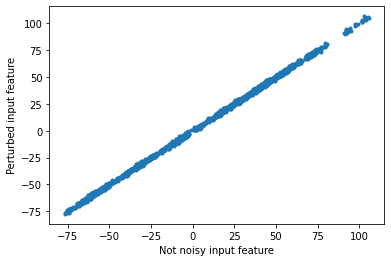

In [341]:
ch = 0
plt.plot(Xtrain[:,ch] - noise[:,ch], Xtrain[:,ch],'.')
plt.xlabel('Not noisy input feature')
plt.ylabel('Perturbed input feature');

In [272]:
X[:ntrain+nval].shape

(2336, 200)

In [268]:
print('ML is given the following inputs:')
full_label

ML is given the following inputs:


['Xe t+1 PC0',
 'Xe t+1 PC1',
 'Xe t+1 PC2',
 'Xe t+1 PC3',
 'Xe t+1 PC4',
 'Xe t+1 PC5',
 'Xe t+1 PC6',
 'Xe t+1 PC7',
 'Xe t+2 PC0',
 'Xe t+2 PC1',
 'Xe t+2 PC2',
 'Xe t+2 PC3',
 'Xe t+2 PC4',
 'Xe t+2 PC5',
 'Xe t+2 PC6',
 'Xe t+2 PC7',
 'SITf t+0 PC0',
 'SITf t+0 PC1',
 'SITf t+0 PC2',
 'SITf t+0 PC3',
 'SITf t+0 PC4',
 'SITf t+0 PC5',
 'SITf t+0 PC6',
 'SITf t+0 PC7',
 'SITf t+1 PC0',
 'SITf t+1 PC1',
 'SITf t+1 PC2',
 'SITf t+1 PC3',
 'SITf t+1 PC4',
 'SITf t+1 PC5',
 'SITf t+1 PC6',
 'SITf t+1 PC7',
 'SITf t+2 PC0',
 'SITf t+2 PC1',
 'SITf t+2 PC2',
 'SITf t+2 PC3',
 'SITf t+2 PC4',
 'SITf t+2 PC5',
 'SITf t+2 PC6',
 'SITf t+2 PC7',
 'SITf t+3 PC0',
 'SITf t+3 PC1',
 'SITf t+3 PC2',
 'SITf t+3 PC3',
 'SITf t+3 PC4',
 'SITf t+3 PC5',
 'SITf t+3 PC6',
 'SITf t+3 PC7',
 '2T_mea t+0 PC0',
 '2T_mea t+0 PC1',
 '2T_mea t+0 PC2',
 '2T_mea t+0 PC3',
 '2T_mea t+1 PC0',
 '2T_mea t+1 PC1',
 '2T_mea t+1 PC2',
 '2T_mea t+1 PC3',
 '2T_mea t+2 PC0',
 '2T_mea t+2 PC1',
 '2T_mea t+2 PC2',
 '2T_me

## A first simple model

In [42]:
from sklearn.model_selection import TimeSeriesSplit

from src.visualization.time_serie_split import PlotTimeSerieSplit

In [306]:
nsplit = 4
max_test_size = int(Xtrain.shape[0]/(nsplit +1))


In [307]:
ts_cv = TimeSeriesSplit(
    n_splits=nsplit,
    gap=0,
    max_train_size=ntrain,
   test_size=max_test_size,
)
# test_size = nval -> train dataset too small for the first split

In [ ]:
# unique train/test split
# indexes = np.arange(X.shape[0])[:]
# idx_test = indexes[ntrain+nval:ntrain+nval+ntest]
# idx_train = indexes[:ntrain+nval]
# tt = [(idx_train, idx_test)]

In [298]:
Xtrain.shape

(2336, 200)

In [297]:
chrono[-ntrain:].shape

(2336,)

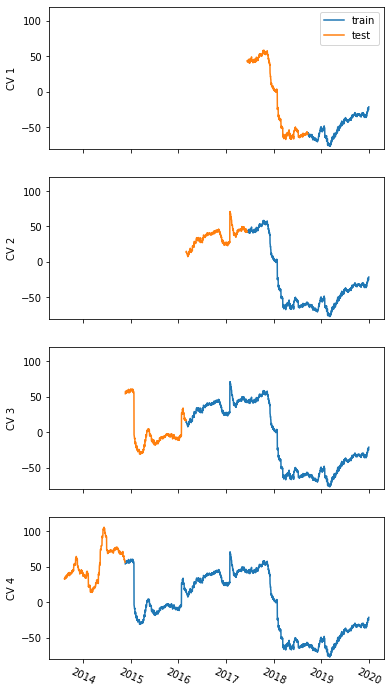

In [308]:
PlotTimeSerieSplit(ts_cv, Xtrain, chrono[-ntrain:], rootdir+fig_dir, False, True)

----

In [ ]:
# bts_cv = BlockingTimeSeriesSplit(3)
# PlotTimeSerieSplit(bts_cv, Xtrain[:,:], chrono, rootdir+fig_dir, False, True)

----

### Initialize variables and model parameters

#### Input variables

In [351]:
ncomp = nfeat

In [342]:
# additional parameters for the model

# cross validation
n_iter_bay = 5 # 100
bayesian_search = False
return_train_score = False
introspect = False

# input variables
input_dico = ''  # default: all variables

# load input_dico, to set selection directly
# ! need same X !
# idir = '/nird/projects/nird/NS2993K/Leo/results/'

# idir = '/cluster/work/users/leoede/Leo/results/grdbst_Npred22_2F_rw21d_N4444_H1333_Hn0000_hice00_artc_220816-205402/ml/'
# ifile = 'input_dico_01.npy'

idir = '/nird/projects/nird/NS2993K/Leo/results/grdbst_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc/ml/'
ifile = 'input_dico.npy'
# dicoback = np.load(f'{idir}{ifile}', allow_pickle=True)
# input_dico = dicoback[None][0]

# load model
# model_to_load = ''


In [352]:
input_dd = mdl_input_dico.InputDico()
input_dd.init_true(ncomp, totlabels)
# input_dd.keep_only_best(ml_model)

In [354]:
input_dd.dico.keys();

dict_keys(['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7'])

In [ ]:
# input_dd.switch_to_true(folabels)

In [ ]:
# input_dd.switch_to_true(hyplabels)

In [ ]:
# input_dd.switch_to_false(['Xe t+1 PC0', 'la', 'Xe t+2 PC2', 'Xtp'])
# input_dd.switch_to_true(['airtmp t+3 PC0', 'airtmp t+6 PC0','airtmp t+9 PC0','airtmp t+12 PC0'])

----

In [348]:
from importlib import reload
reload(mdl_params);

----

#### GridSearch params / Model Params

In [349]:
param = mdl_params.Params(ml_model, ncomp)

# param.get_search(booster='dart')
param.optimize(random_state=0, booster='dart')

In [356]:
param.param_opt.keys()

dict_keys(['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7'])

### Initialize model

In [357]:
from src.modelling import model_ridge
from src.modelling import model_rf
from src.modelling import model_grdbst
from src.modelling import model_xgboost
# from src.modelling import model_lstm


from src.modelling import model_utils

ml_classes = [model_ridge, model_rf, model_grdbst, model_xgboost]  # , model_lstm]  # etc
ml_classes_name = ['model_ridge', 'model_rf', 'model_grdbst', 'model_xgboost']  # , 'model_lstm']

In [358]:
# to load a specific model
# m1 = model_grdbst.ModelML(nfeat)
# m1.load('path/to/model/model_grdbst.joblib')  # or .save ?

In [359]:
ml_model

'xgb'

In [360]:
# pick the corresponding machine learning model
ml_idx = [i for i, cl in enumerate(ml_classes_name) if ml_model in cl][0]

In [361]:
m1 = ml_classes[ml_idx].ModelML(nfeat, ntest, ntrain, totlabels, rootdir, ml_dir, fig_dir)

m1.generate_model()

In [362]:
# m1.dict_grid

In [363]:
# same parameters for all PCA
# m1.gridCV(param_grid, ts_cv, bayesian=bayesian_search, n_iter_bay=n_iter_bay, return_train_score=return_train_score)

In [364]:
# DIFFERENT PARAMETERS FOR EACH PCA
m1.improved_gridCV(param.param_opt, ts_cv, bayesian=bayesian_search, n_iter_bay=n_iter_bay, return_train_score=return_train_score)


In [365]:
m1.input_dico = ''

In [366]:
# m1.input_dico = input_dd.dico  # input_dico
m1.full_label = full_label

In [232]:
input_dd.dico;  # ['pc0'].shape

----

In [ ]:
m1.dico_param;

## FIRST FIT - LOOP FIT

In [ ]:
# m1.dict_grid['pc0'].best_estimator_['randomforestregressor'].n_estimators_
# il ny a pas de arg: .n_estimators_ in randomforest

In [367]:
m1.improved_fit(Xtrain, ytrain)

pc0 fit with 200 variables
['Xe t+1 PC0' 'Xe t+1 PC1' 'Xe t+1 PC2' 'Xe t+1 PC3' 'Xe t+1 PC4'
 'Xe t+1 PC5' 'Xe t+1 PC6' 'Xe t+1 PC7' 'Xe t+2 PC0' 'Xe t+2 PC1'
 'Xe t+2 PC2' 'Xe t+2 PC3' 'Xe t+2 PC4' 'Xe t+2 PC5' 'Xe t+2 PC6'
 'Xe t+2 PC7' 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+0 PC4' 'SITf t+0 PC5' 'SITf t+0 PC6' 'SITf t+0 PC7'
 'SITf t+1 PC0' 'SITf t+1 PC1' 'SITf t+1 PC2' 'SITf t+1 PC3'
 'SITf t+1 PC4' 'SITf t+1 PC5' 'SITf t+1 PC6' 'SITf t+1 PC7'
 'SITf t+2 PC0' 'SITf t+2 PC1' 'SITf t+2 PC2' 'SITf t+2 PC3'
 'SITf t+2 PC4' 'SITf t+2 PC5' 'SITf t+2 PC6' 'SITf t+2 PC7'
 'SITf t+3 PC0' 'SITf t+3 PC1' 'SITf t+3 PC2' 'SITf t+3 PC3'
 'SITf t+3 PC4' 'SITf t+3 PC5' 'SITf t+3 PC6' 'SITf t+3 PC7'
 '2T_mea t+0 PC0' '2T_mea t+0 PC1' '2T_mea t+0 PC2' '2T_mea t+0 PC3'
 '2T_mea t+1 PC0' '2T_mea t+1 PC1' '2T_mea t+1 PC2' '2T_mea t+1 PC3'
 '2T_mea t+2 PC0' '2T_mea t+2 PC1' '2T_mea t+2 PC2' '2T_mea t+2 PC3'
 '2T_mea t+3 PC0' '2T_mea t+3 PC1' '2T_mea t+3 PC2' '2T_mea t+3 PC3

pc3 fit with 200 variables
['Xe t+1 PC0' 'Xe t+1 PC1' 'Xe t+1 PC2' 'Xe t+1 PC3' 'Xe t+1 PC4'
 'Xe t+1 PC5' 'Xe t+1 PC6' 'Xe t+1 PC7' 'Xe t+2 PC0' 'Xe t+2 PC1'
 'Xe t+2 PC2' 'Xe t+2 PC3' 'Xe t+2 PC4' 'Xe t+2 PC5' 'Xe t+2 PC6'
 'Xe t+2 PC7' 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+0 PC4' 'SITf t+0 PC5' 'SITf t+0 PC6' 'SITf t+0 PC7'
 'SITf t+1 PC0' 'SITf t+1 PC1' 'SITf t+1 PC2' 'SITf t+1 PC3'
 'SITf t+1 PC4' 'SITf t+1 PC5' 'SITf t+1 PC6' 'SITf t+1 PC7'
 'SITf t+2 PC0' 'SITf t+2 PC1' 'SITf t+2 PC2' 'SITf t+2 PC3'
 'SITf t+2 PC4' 'SITf t+2 PC5' 'SITf t+2 PC6' 'SITf t+2 PC7'
 'SITf t+3 PC0' 'SITf t+3 PC1' 'SITf t+3 PC2' 'SITf t+3 PC3'
 'SITf t+3 PC4' 'SITf t+3 PC5' 'SITf t+3 PC6' 'SITf t+3 PC7'
 '2T_mea t+0 PC0' '2T_mea t+0 PC1' '2T_mea t+0 PC2' '2T_mea t+0 PC3'
 '2T_mea t+1 PC0' '2T_mea t+1 PC1' '2T_mea t+1 PC2' '2T_mea t+1 PC3'
 '2T_mea t+2 PC0' '2T_mea t+2 PC1' '2T_mea t+2 PC2' '2T_mea t+2 PC3'
 '2T_mea t+3 PC0' '2T_mea t+3 PC1' '2T_mea t+3 PC2' '2T_mea t+3 PC3

pc6 fit with 200 variables
['Xe t+1 PC0' 'Xe t+1 PC1' 'Xe t+1 PC2' 'Xe t+1 PC3' 'Xe t+1 PC4'
 'Xe t+1 PC5' 'Xe t+1 PC6' 'Xe t+1 PC7' 'Xe t+2 PC0' 'Xe t+2 PC1'
 'Xe t+2 PC2' 'Xe t+2 PC3' 'Xe t+2 PC4' 'Xe t+2 PC5' 'Xe t+2 PC6'
 'Xe t+2 PC7' 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+0 PC4' 'SITf t+0 PC5' 'SITf t+0 PC6' 'SITf t+0 PC7'
 'SITf t+1 PC0' 'SITf t+1 PC1' 'SITf t+1 PC2' 'SITf t+1 PC3'
 'SITf t+1 PC4' 'SITf t+1 PC5' 'SITf t+1 PC6' 'SITf t+1 PC7'
 'SITf t+2 PC0' 'SITf t+2 PC1' 'SITf t+2 PC2' 'SITf t+2 PC3'
 'SITf t+2 PC4' 'SITf t+2 PC5' 'SITf t+2 PC6' 'SITf t+2 PC7'
 'SITf t+3 PC0' 'SITf t+3 PC1' 'SITf t+3 PC2' 'SITf t+3 PC3'
 'SITf t+3 PC4' 'SITf t+3 PC5' 'SITf t+3 PC6' 'SITf t+3 PC7'
 '2T_mea t+0 PC0' '2T_mea t+0 PC1' '2T_mea t+0 PC2' '2T_mea t+0 PC3'
 '2T_mea t+1 PC0' '2T_mea t+1 PC1' '2T_mea t+1 PC2' '2T_mea t+1 PC3'
 '2T_mea t+2 PC0' '2T_mea t+2 PC1' '2T_mea t+2 PC2' '2T_mea t+2 PC3'
 '2T_mea t+3 PC0' '2T_mea t+3 PC1' '2T_mea t+3 PC2' '2T_mea t+3 PC3

In [368]:
m1.improved_predict(X, y)

In [161]:
m1.nsplit = nsplit

In [ ]:
# m1.compute_score_staged_nest()
# mdl_introspect.plot_cvscore_nboosting_iter(m1, showfig=True)

In [ ]:
if bayesian_search and m1.type == 'grdbst':
    mdl_introspect.plot_optimizer_full(m1, showfig=True)    

#### Evaluation training phase

In [113]:
m1.eval_grid_cv()



 pc0
CV results:
{'mean_fit_time': array([52.60101712]),
 'mean_score_time': array([0.98002529]),
 'mean_test_score': array([-1.77169925]),
 'param_xgbregressor__booster': masked_array(data=['dart'],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__colsample_bytree': masked_array(data=[0.45686],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__learning_rate': masked_array(data=[0.554],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__max_depth': masked_array(data=[2],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__n_estimators': masked_array(data=[103],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__random_state': masked_array(data=[0],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__

{'memory': None,
 'minmaxscaler': MinMaxScaler(),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'steps': [('minmaxscaler', MinMaxScaler()),
           ('xgbregressor',
            XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.62, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             rate_drop=0.1, reg_alpha=0, ...))],
 'verbose': False,
 'xgbregressor': XGBRegressor(base_score=0.5, booster='dart', 

### Recursive prediction

In [73]:
m1.set_target_history(H)

In [80]:
m1.recursive_prediction_multiple(X,y, init_test=True)

todo: put that in a script in src/modelling/recursive_prediction.py


### Sequence recursive prediction

In [61]:
print('Score prediction recursive sequence')
m1.score_prediction()

Score prediction recursive sequence


AttributeError: 'ModelML' object has no attribute 'yrec'

### Visual evaluation of the prediction

In [62]:
from src.visualization import mdl_scatter_pred as msp
from src.visualization import mdl_non_recursive
from src.visualization import mdl_recursive
from src.visualization import mdl_recursive_sequence

In [72]:
ntrain

2704

In [71]:
m1.y.shape

(2704, 4)

In [167]:
chrono[-nresize-1:].shape

(2921,)

In [370]:
m1.chrono = chrono[-nresize-1:]

In [103]:
m1.ypredict.shape

(2704, 4)

In [105]:
Xtrain.shape

(2704, 176)

In [170]:
y.shape

(2920, 4)

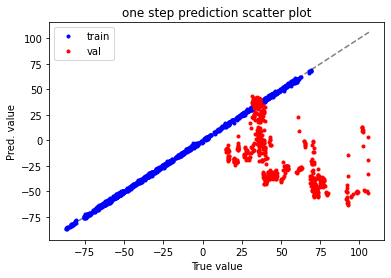

In [334]:
msp.draw_non_recursive(m1,0)

In [111]:
reload(mdl_non_recursive)

<module 'src.visualization.mdl_non_recursive' from '/cluster/home/leoede/tardis/tardis-ml/src/visualization/mdl_non_recursive.py'>

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/ML_predicted_non_recursive_03.png


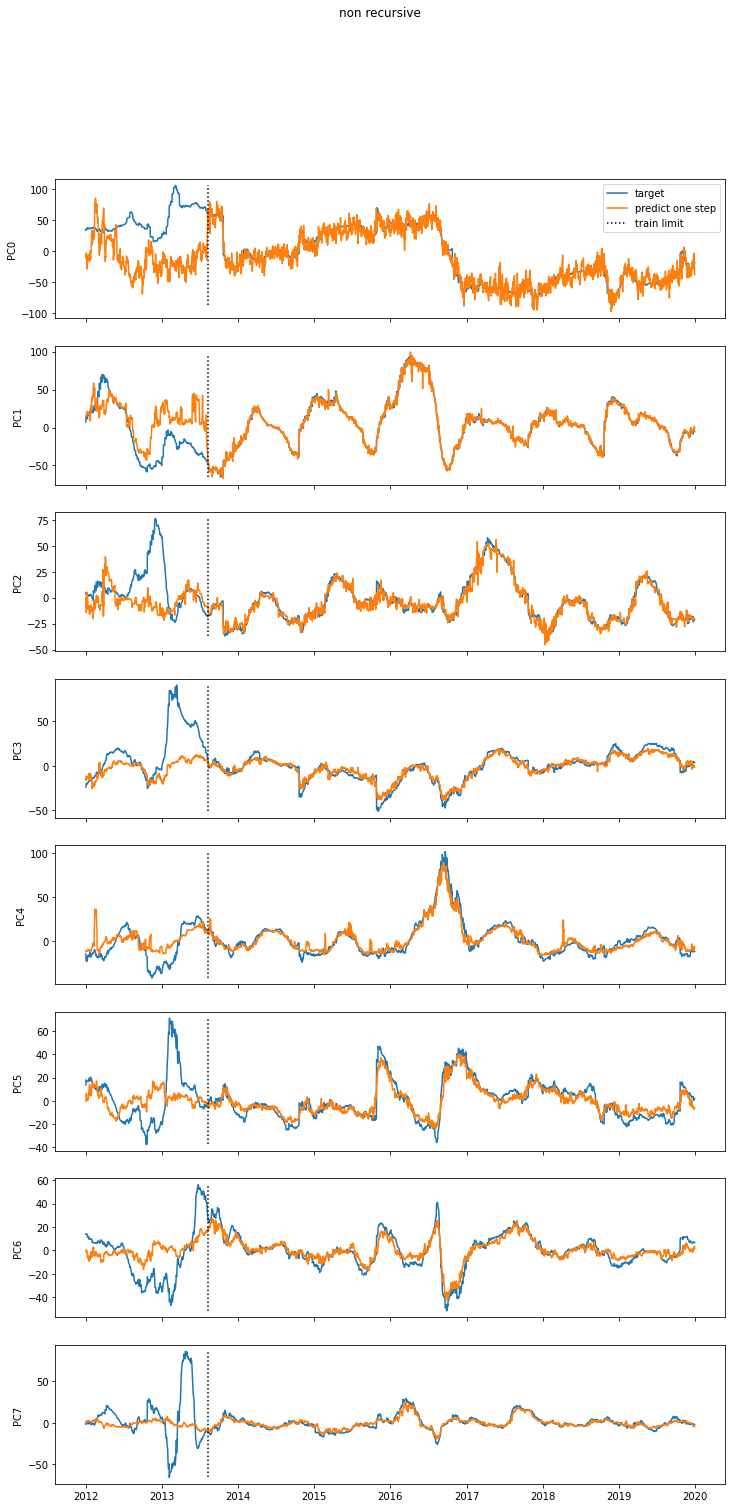

In [371]:
mdl_non_recursive.draw(m1, odir= m1.rootdir + m1.fig_dir, savefig=True)

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/ML_prediction_recursive_01.png


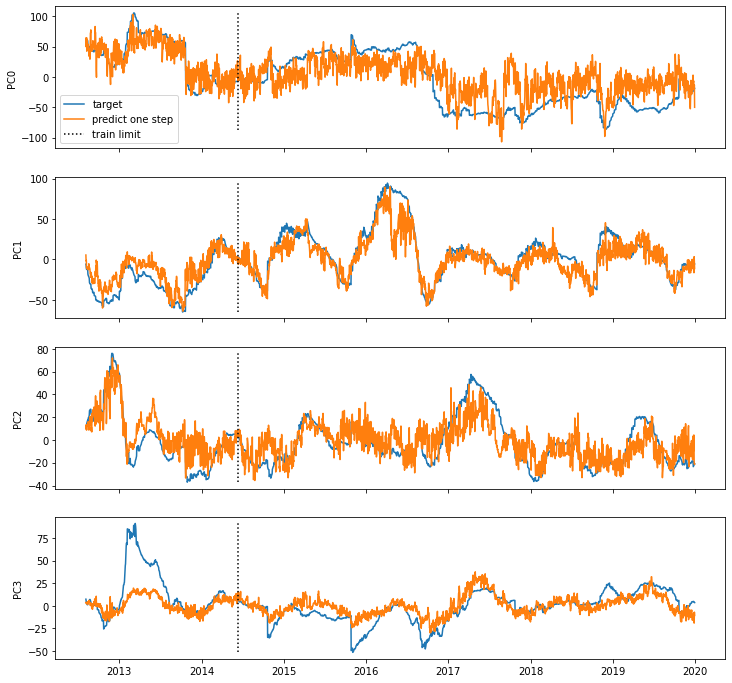

In [81]:
mdl_recursive.draw(m1, odir= m1.rootdir + m1.fig_dir, savefig=True, showfig=True, force=True)

-----

In [ ]:
from importlib import reload
reload(mdl_introspect);

In [ ]:
mdl_recursive_sequence.draw_seq(m1, savefig=False)

In [ ]:
mdl_recursive_sequence.draw(m1, savefig=True, odir= m1.rootdir + m1.fig_dir)

----

In [ ]:
# mrs.draw_seq(m1, savefig=True)
mdl_recursive_sequence.draw(m1, max_plot=8, savefig=True)

In [ ]:
reload(msp)

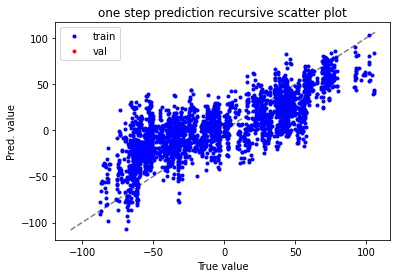

In [94]:
msp.draw_recursive(m1,0)

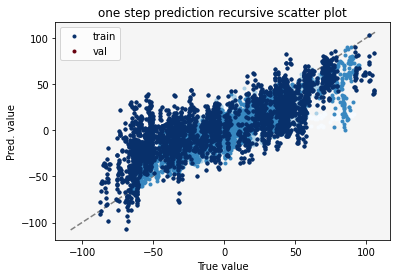

In [95]:
msp.draw_recursive_allfeat(m1, savefig=False)

------

### Evaluation variables importance

In [84]:
from src.visualization import visu_mdl_importance

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/importance_allPC_03.png


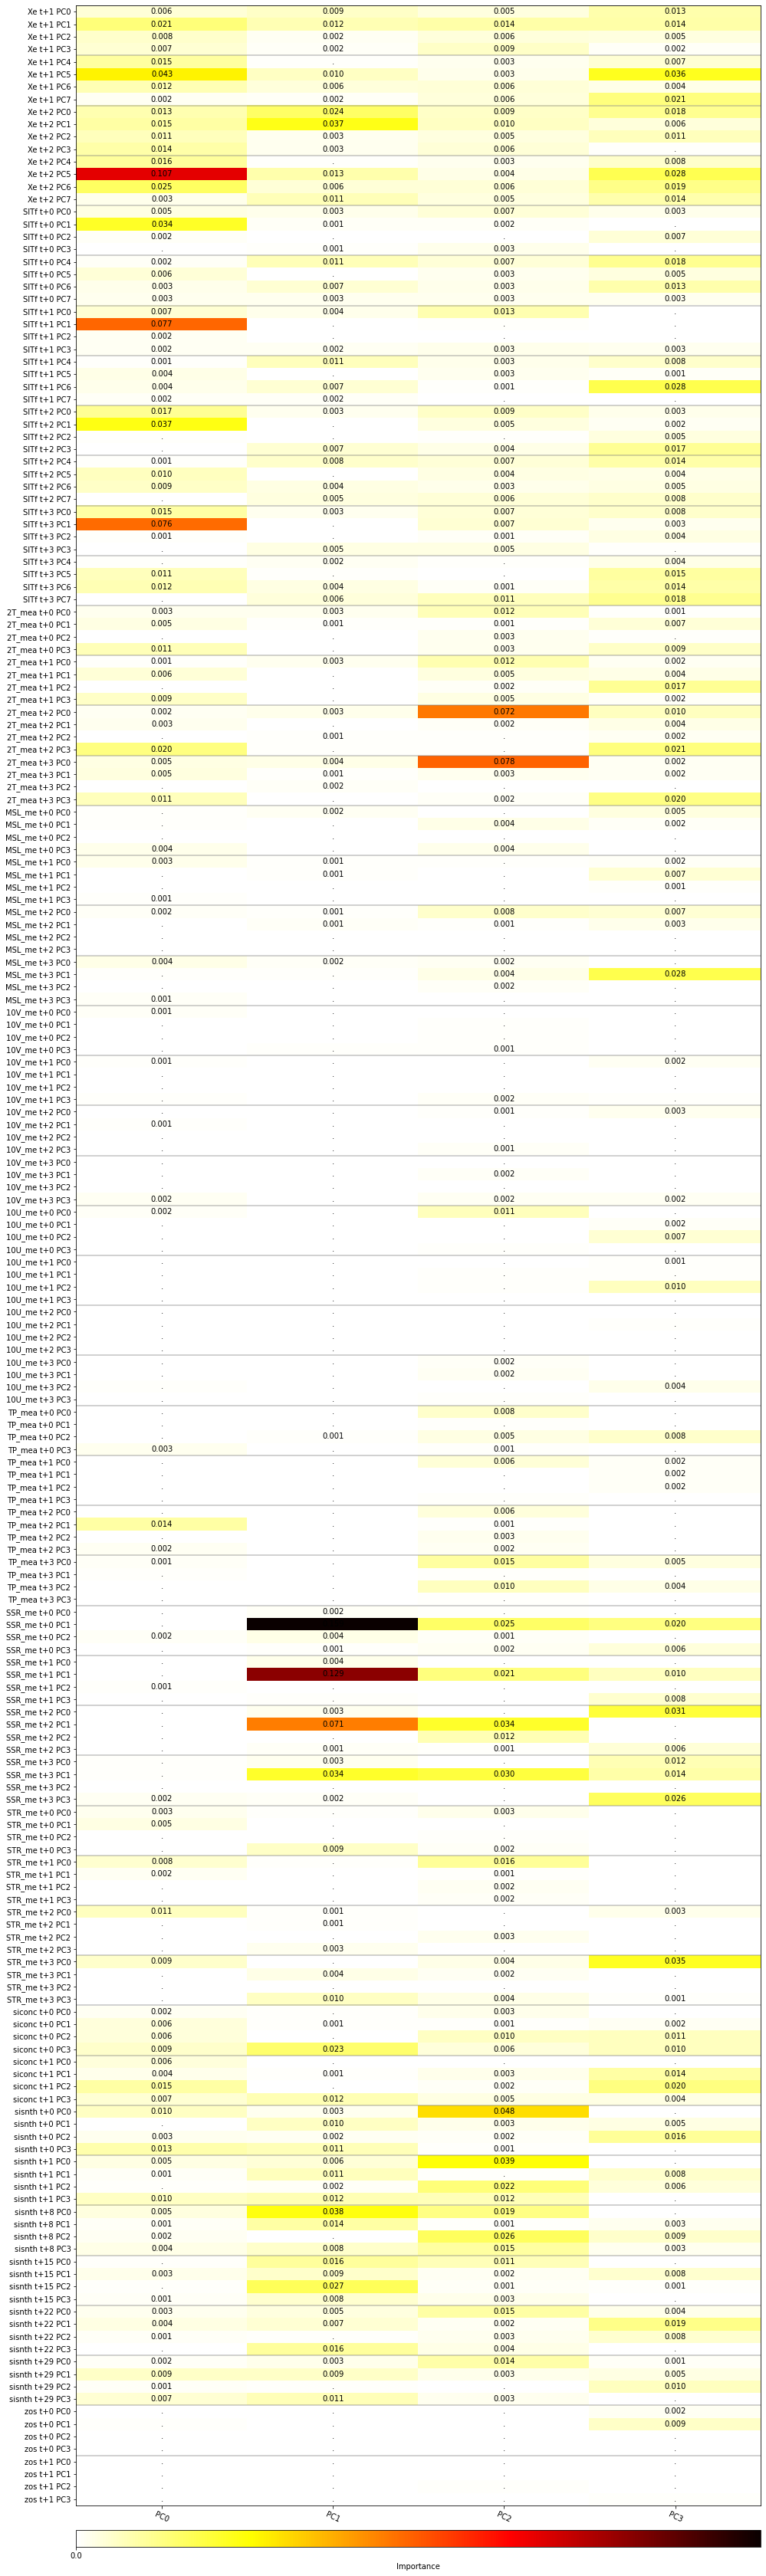

In [335]:
visu_mdl_importance.plot_importance_var_allpca(m1, savefig=True, showfig=True)

In [82]:
m1.dict_grid[f'pc{0}'].best_estimator_['xgbregressor'].feature_importances_

array([0.02958685, 0.0661945 , 0.0162646 , 0.00652253, 0.00470569,
       0.00960442, 0.01818333, 0.00335826, 0.01746339, 0.01650731,
       0.00168275, 0.00563468, 0.00264754, 0.0026184 , 0.03463104,
       0.00669349, 0.06816283, 0.01003367, 0.0035839 , 0.01671678,
       0.00662908, 0.00481729, 0.01747352, 0.00969011, 0.01208014,
       0.03820848, 0.00328671, 0.01991012, 0.01371318, 0.0052789 ,
       0.0024292 , 0.02994251, 0.        , 0.01368974, 0.00089798,
       0.        , 0.        , 0.        , 0.00379863, 0.00485421,
       0.        , 0.00285844, 0.00754908, 0.00406577, 0.00615687,
       0.00518282, 0.00210703, 0.        , 0.        , 0.00199177,
       0.        , 0.        , 0.02334722, 0.00540448, 0.00368825,
       0.007878  , 0.        , 0.        , 0.00468291, 0.00750433,
       0.00309367, 0.        , 0.00454864, 0.00418515, 0.        ,
       0.        , 0.0035671 , 0.00254068, 0.00251297, 0.00219688,
       0.00803479, 0.00668968, 0.        , 0.00282596, 0.00358

In [ ]:
# most importantes features
# i_pca = 0

# CASSE !!!!!!!!!!!!!!!!!!!! 

print('from GrdBstRegressor')
for Nf in range(4):
#     index = np.argsort(m1.dict_grid[f'pc{Nf}'].best_estimator_['gradientboostingregressor'].feature_importances_)
    index = np.argsort(m1.dict_grid[f'pc{Nf}'].best_estimator_['xgbregressor'].feature_importances_)
    
    most = 10
    name_most = np.array(m1.full_label)[index][::-1][:most]
#     print(name_most)
#     imp_most = m1.dict_grid[f'pc{Nf}'].best_estimator_['gradientboostingregressor'].feature_importances_[index][::-1][:most]
    imp_most = m1.dict_grid[f'pc{Nf}'].best_estimator_['xgbregressor'].feature_importances_[index][::-1][:most]
    
    print(f'\n10 most important variables, PC{Nf}:')
    for name, imp in zip(name_most, imp_most):
        print(f'{name:<15}', '   :   ', imp)



#### Compute permutation importance

In [ ]:
# put 0 instead of nan for permutation test
yrr = m1.yrec.copy()
yrr[np.where(np.isnan(m1.yrec))] = 0

m1.yrec = yrr

In [88]:
# permutation test
m1.compute_permutation_imp(redo=True)

! Random State = 0


In [ ]:
# permutation test on TRAIN Period
m1.compute_permutation_imp_train()

 -----

### check one tree

 -----

### Visu importance permu test

In [90]:
from src.visualization import mdl_permu_test

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/PermuImp_testset_xgb_PC0.png


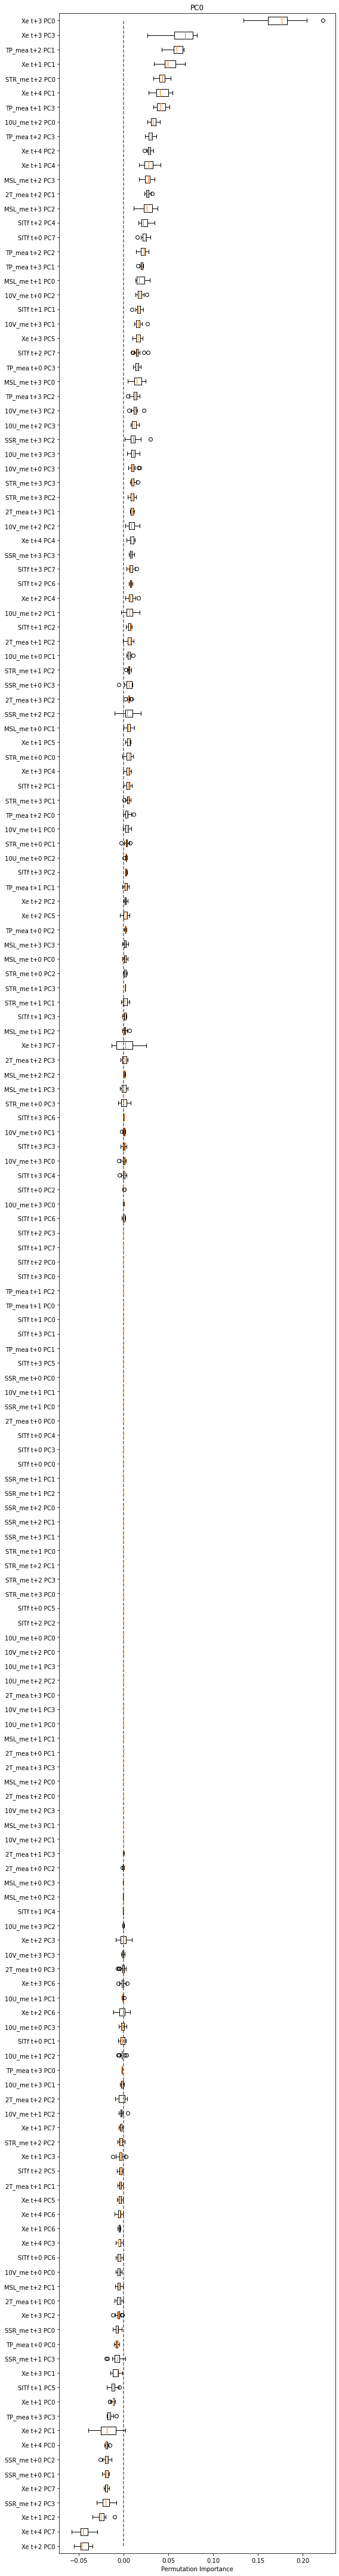

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/PermuImp_testset_xgb_PC1.png


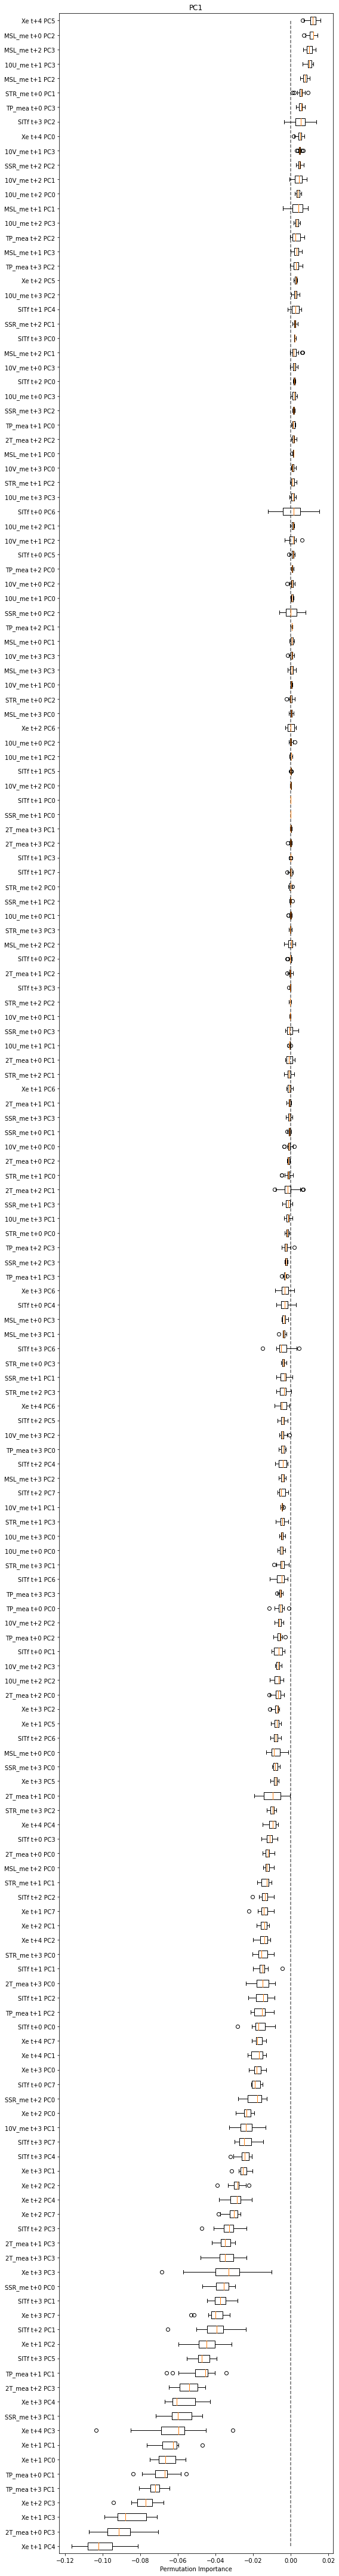

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/PermuImp_testset_xgb_PC2.png


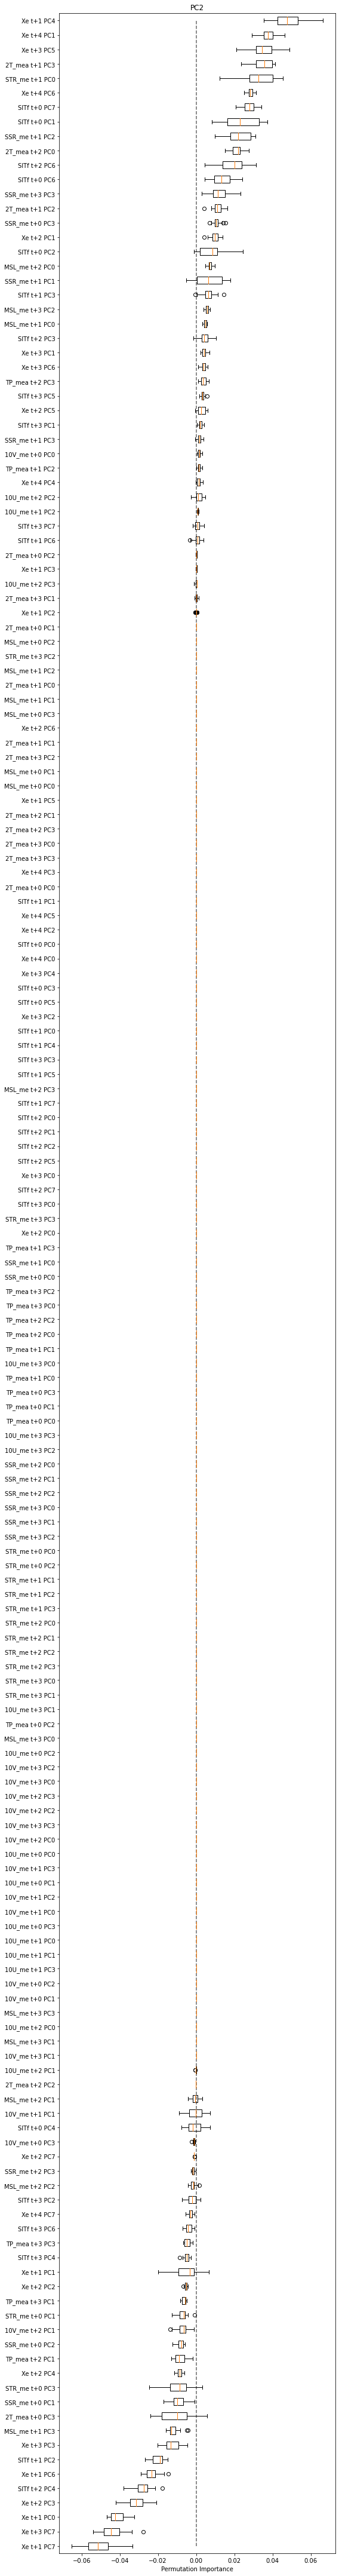

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/PermuImp_testset_xgb_PC3.png


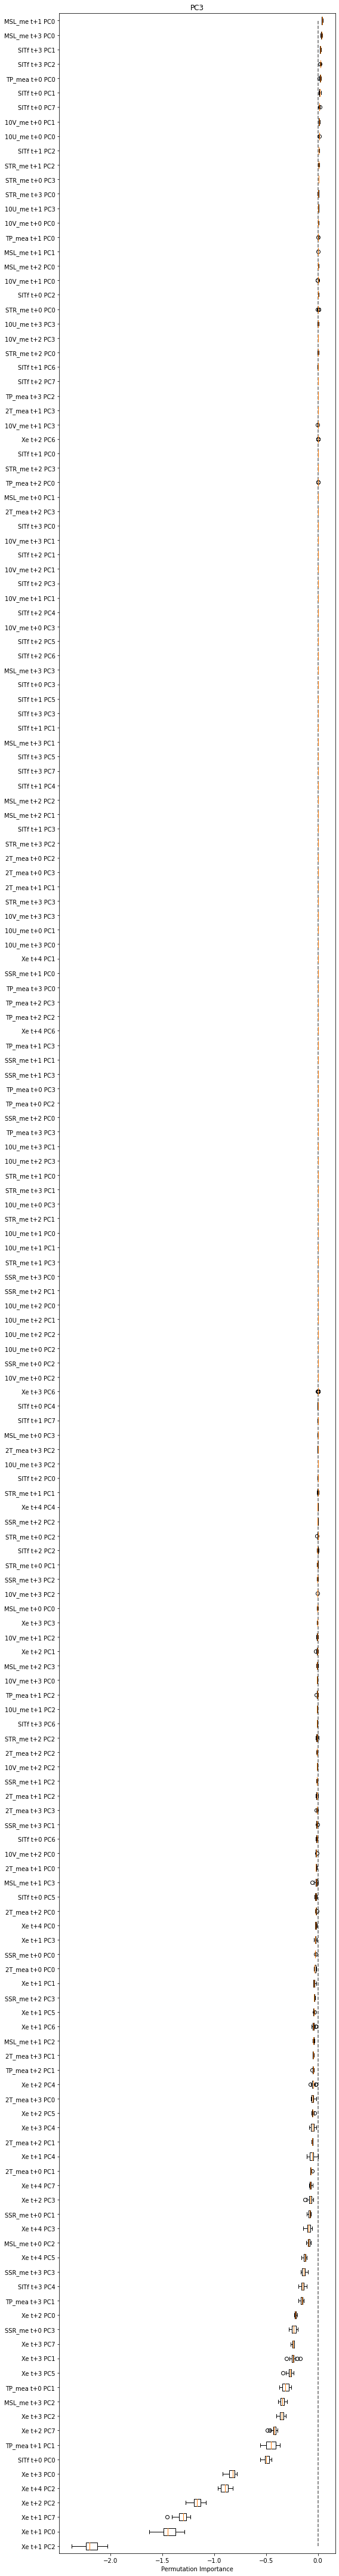

In [91]:
for i in range(4):
    mdl_permu_test.draw_permu_1pc(m1, i_pca=i, savefig=True, showfig=True)

In [ ]:
for i in range(4):
    mdl_permu_test.draw_permu_1pc(m1, i_pca=i, train=True, savefig=True, showfig=True)

### On garde seulement variables avec importance > 0

In [93]:
# on fit 1 algo par PCA car input differentes
m1.keep_var_imp(threshold=0.00, most_imp=.5)

Keep var important


TypeError: string indices must be integers

In [ ]:
m1.keep_best_param()

In [ ]:
# keep best params for next iteration

In [ ]:
# save input_dico
# in keep_var_imp()

In [ ]:
# input_dico shall be the same size forever
# tokeep (indexes) must keep the same size

# if var in false at iteration 1: 
# put it false at iteration 2, and importance = np.nan

In [ ]:
print(m1.input_dico);

 -----

 -----

### Save best estimator ML for later use

In [87]:
m1.save_best_est()

# save input_dico as well

ML model saved as:
/nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/ml/xgb_param_todo.save


In [379]:
ntrain, ntest

(2336, 584)

In [377]:
m1.save_ypred()

Yrec (prediction recursive) saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/ml/yrec_01.npy


### Reconstruct values 

-----